# Occupancy Detection 

In [1]:
#Import Libraries 

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import csv
import os
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from pandas import DataFrame 
from sklearn.model_selection import KFold
from scipy.stats import zscore
from scipy import stats 
import torch
import torch.nn as nn 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from matplotlib.pyplot import figure
from matplotlib.pyplot import title
from sklearn.metrics import mean_squared_error 

%matplotlib inline
sns.set()

## Read in Data for each feature

In [2]:
#Define the directory path to search for data 
main_directory_path = "Datasets/Data-Berkeley/KETI/"

# Create a list to store the data into 
co2_df = []
humidity_df = []
temperature_df = []
light_df = [] 
pir_df=[]

#Read each file in each subfolder in the directory 
for directory, subfolder, file in os.walk(main_directory_path):

    #For each file in the subfolder
    for CSV_name in file:
        
        #Check if the file contains "co2" in it and append it
        if CSV_name.endswith(".csv") and "co2" in CSV_name:
            
            #Define a file path for the file to be read
            file_path = os.path.join(directory, CSV_name)
            temp_df = pd.read_csv(file_path,names=["Time Stamp","CO2"])

            # Add a new column with the subfolder name
            temp_df['Room ID'] = os.path.basename(directory)

            co2_df.append(temp_df)

         #Check if the file contains "Humidity" in it and append it
        if CSV_name.endswith(".csv") and "humidity" in CSV_name:
            
            #Define a file path for the file to be read
            file_path = os.path.join(directory, CSV_name)
            temp_df = pd.read_csv(file_path,names=["Time Stamp","humidity"])

            # Add a new column with the subfolder name
            temp_df['Room ID'] = os.path.basename(directory)

            humidity_df.append(temp_df)

        #Check if the file contains "temperature" in it and append it
        if CSV_name.endswith(".csv") and "temperature" in CSV_name:
            
            #Define a file path for the file to be read
            file_path = os.path.join(directory, CSV_name)
            temp_df = pd.read_csv(file_path,names=["Time Stamp","temperature"])

            # Add a new column with the subfolder name
            temp_df['Room ID'] = os.path.basename(directory)

            temperature_df.append(temp_df)

        #Check if the file contains "pir" in it and append it
        if CSV_name.endswith(".csv") and "pir" in CSV_name:
            
            #Define a file path for the file to be read
            file_path = os.path.join(directory, CSV_name)
            temp_df = pd.read_csv(file_path,names=["Time Stamp","pir"])

            # Add a new column with the subfolder name
            temp_df['Room ID'] = os.path.basename(directory)

            pir_df.append(temp_df)

        #Check if the file contains "pir" in it and append it
        if CSV_name.endswith(".csv") and "light" in CSV_name:
            
            #Define a file path for the file to be read
            file_path = os.path.join(directory, CSV_name)
            temp_df = pd.read_csv(file_path,names=["Time Stamp","light"])

            # Add a new column with the subfolder name
            temp_df['Room ID'] = os.path.basename(directory)

            light_df.append(temp_df)

    # Concatenate all the DataFrames into a single DataFrame
  
co2_df = pd.concat(co2_df,ignore_index= False , axis=0)
humidity_df = pd.concat(humidity_df,ignore_index=False,axis=0) 
temperature_df = pd.concat(temperature_df,ignore_index=False,axis=0)
pir_df = pd.concat(pir_df,ignore_index=False,axis=0) 
light_df = pd.concat(light_df,ignore_index=False,axis=0)

In [3]:
merged_1 = pd.merge(co2_df, humidity_df, on=['Time Stamp', 'Room ID'])
merged_2 = pd.merge(temperature_df, pir_df, on=['Time Stamp', 'Room ID'])
merged_3 = pd.merge(merged_1, light_df, on=['Time Stamp', 'Room ID'])
merged = pd.merge(merged_2, merged_3, on=['Time Stamp', 'Room ID'])
merged

,Time Stamp,temperature,Room ID,pir,CO2,humidity,light
0,1377299108,23.94,413,0.0,495.0,45.34,97.0
1,1377457084,23.48,413,0.0,459.0,52.75,103.0
2,1377457963,23.50,413,0.0,456.0,52.71,104.0
3,1377462175,23.54,413,0.0,446.0,52.43,105.0
4,1377464765,23.56,413,0.0,463.0,52.30,111.0
...,...,...,...,...,...,...,...
135381,1377965997,23.02,776,0.0,496.0,56.67,153.0
135382,1377966724,23.16,776,0.0,504.0,56.42,157.0
135383,1377968206,23.43,776,0.0,497.0,55.86,141.0
135384,1377968924,23.55,776,0.0,508.0,55.73,129.0


## Explorative Analysis

In [4]:
merged['pir'].unique()

array([ 0., 26., 30., 11., 29., 27., 28., 25., 10., 24., 23., 22., 21.,
       20., 19., 18., 17.,  4., 16., 14., 13.,  8.,  5.,  3.,  1., 15.,
       12.,  9.,  7.,  6.,  2.])

In [5]:
df = merged  

df.describe()

,Time Stamp,temperature,pir,CO2,humidity,light
count,1.353860e+05,135386.000000,135386.000000,135386.000000,135386.000000,135386.000000
mean,1.377642e+09,23.415895,1.666805,399.274231,56.891766,140.571861
std,2.021197e+05,11.836374,6.508214,119.081858,3.611998,470.686763
min,1.377299e+09,20.200000,0.000000,62.000000,42.120000,0.000000
25%,1.377459e+09,22.610000,0.000000,334.000000,54.420000,4.000000
50%,1.377671e+09,23.110000,0.000000,408.000000,57.280000,4.000000
75%,1.377823e+09,23.660000,0.000000,464.000000,59.100000,37.000000
max,1.377973e+09,579.270000,30.000000,1223.000000,71.290000,2397.000000


### Determine occupancy

In [6]:
data_rows = len(df.index)
num_pir = 0
for i in range (data_rows):
    if df['pir'][i] != 0:
        num_pir += 1
print("There are",data_rows,"data points")
print("and there are",int(num_pir),"instances where it is occupied")
print("This is",int(num_pir/ data_rows * 100),"% of the data")

There are 135386 data points
and there are 9097 instances where it is occupied
This is 6 % of the data


### Original Correlation Matrix

<AxesSubplot: >

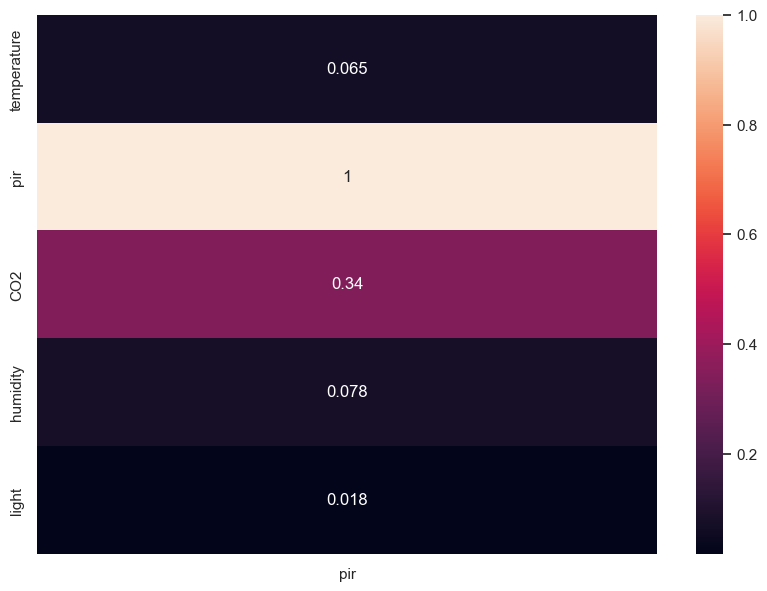

In [7]:
df = df.drop(columns="Time Stamp")
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(data=correlation_matrix[['pir']].abs(),annot=True)

## Data Processing

### IQR Filtering



In [8]:
# create a copy of the selected columns from the original df
IQR = df
columns_to_evaluate = ['temperature', 'CO2', 'humidity', 'light']
iqr_df = df[columns_to_evaluate].copy()

#print the first few rows of the resulting normalized DataFrame
iqr_df = iqr_df.rename(columns={'temperature':'z_temp','CO2':'z_CO2','humidity':'z_hum','light':'z_light'})

#Outliers are identified to be data points with a z-score greater than 3 or less than -3 
#outliers >3 and <-3 indicate that the data falls outside of approximately 99.7% of the dataset 

# Set the positive and negative threshold values
q1 = iqr_df.quantile(0.25)
q3 = iqr_df.quantile(0.75)
iqr = q3 - q1
threshold = 1.5
lower_bound = q1 - (threshold * iqr)
upper_bound = q3 + (threshold * iqr)

# identify outliers by IQR on selected columns
outliers = ((iqr_df < lower_bound) | (iqr_df > upper_bound)).any(axis=1)

# drop the rows containing outliers
IQR = IQR[~outliers]

IQR

df = IQR

<AxesSubplot: >

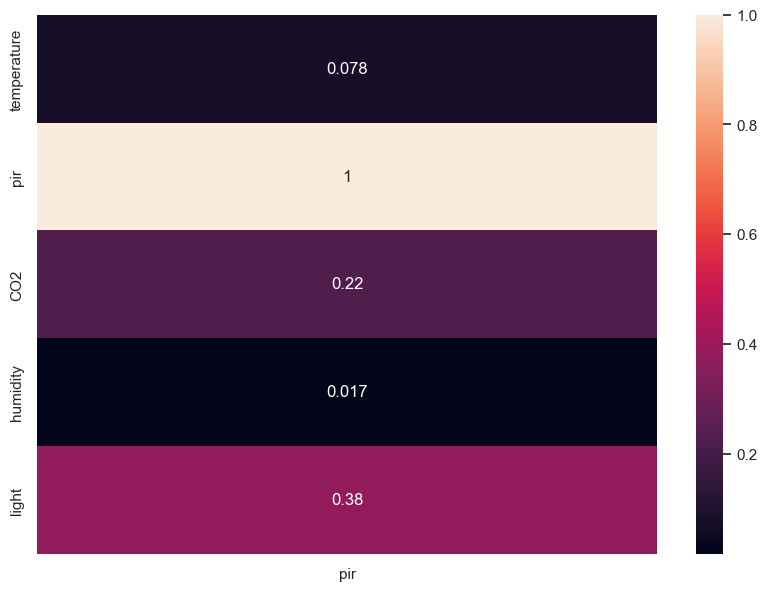

In [9]:
correlation_matrix = IQR.corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(data=correlation_matrix[['pir']].abs(),annot=True)

### Z-score Filtering

In [10]:
# create a copy of the selected columns from the original df
columns_to_evaluate = ['temperature', 'CO2', 'humidity', 'light']
zscore_df = df[columns_to_evaluate].copy()

# apply z-score normalization to each column in the copy
zscore_df = zscore_df.apply(zscore)

#print the first few rows of the resulting normalized DataFrame
zscore_df = zscore_df.rename(columns={'temperature':'z_temp','CO2':'z_CO2','humidity':'z_hum','light':'z_light'})
print (zscore_df)

#Outliers are identified to be data points with a z-score greater than 3 or less than -3 
#outliers >3 and <-3 indicate that the data falls outside of approximately 99.7% of the dataset 

# Set the positive and negative threshold values
positive_threshold = 6
negative_threshold = -1*positive_threshold
 
#Combines the datasets to drop the original column
zscore = pd.concat([df, zscore_df],axis=1)

#Only look at the z scores
cols =['z_temp','z_CO2','z_hum','z_light']

#drops the outliers based on the threshold
zscore = zscore[~((zscore[cols] > positive_threshold).any(axis=1) | (zscore[cols] < negative_threshold).any(axis=1))]
zscore = zscore.drop(['z_temp','z_CO2','z_hum','z_light'], axis = 1) 
zscore

df= zscore

          z_temp     z_CO2     z_hum   z_light
10      2.818778  0.880048 -2.766969 -0.221793
11      2.567665  0.713972 -2.757992 -0.290852
12      2.358403  0.522345 -2.689174 -0.359912
13      1.995683  0.624546 -2.641300 -0.290852
14      1.953831  0.509570 -2.662245 -0.290852
...          ...       ...       ...       ...
135376 -0.306192  1.122775 -0.106985  1.988112
135377 -0.320142  1.135550 -0.098009  1.159398
135378 -0.306192  1.186650 -0.115961  1.642814
135379 -0.292241  1.084450 -0.115961  1.919053
135380 -0.278290  1.084450 -0.133914  2.885886

[99967 rows x 4 columns]


<AxesSubplot: >

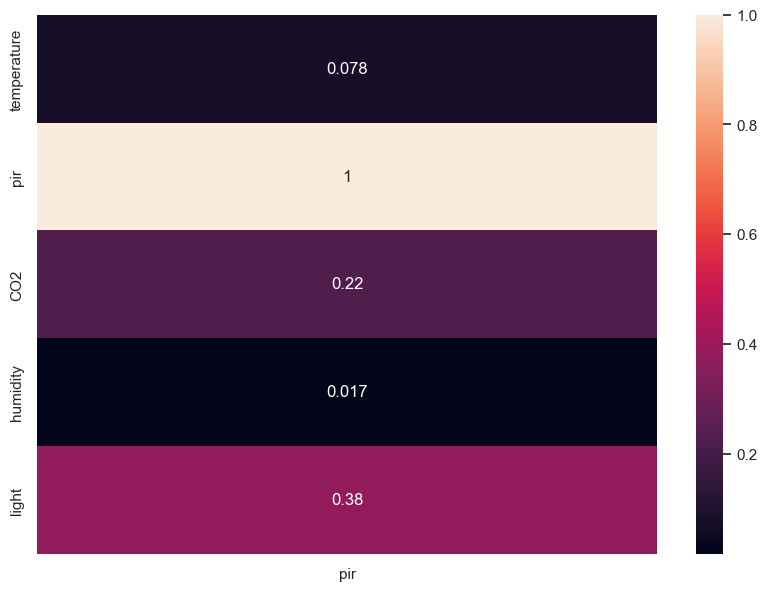

In [11]:
correlation_matrix = zscore.corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(data=correlation_matrix[['pir']].abs(),annot=True)

In [12]:
df

,temperature,Room ID,pir,CO2,humidity,light
10,25.18,413,0.0,476.0,47.90,6.0
11,25.00,413,0.0,463.0,47.93,5.0
12,24.85,413,0.0,448.0,48.16,4.0
13,24.59,413,0.0,456.0,48.32,5.0
14,24.56,413,0.0,447.0,48.25,5.0
...,...,...,...,...,...,...
135376,22.94,776,0.0,495.0,56.79,38.0
135377,22.93,776,0.0,496.0,56.82,26.0
135378,22.94,776,0.0,500.0,56.76,33.0
135379,22.95,776,0.0,492.0,56.76,37.0


In [13]:
if 'pir' in df.columns and not df.empty:
    df.reset_index(drop=True, inplace=True)
    data_rows = len(df.index)
    num_pir = 0
    for i in range(data_rows):
        if df['pir'][i] > 0:
            num_pir += 1
            df.loc[i, 'pir'] = 1
    print("There are", data_rows, "data points")
    print("and there are", num_pir, "instances where it is occupied")
    print("This is", round(num_pir / data_rows * 100, 2), "% of the data")
else:
    print("The DataFrame is empty or does not contain the 'pir' column")


There are 99967 data points
and there are 3501 instances where it is occupied
This is 3.5 % of the data


### Revise PIR

In [14]:
data_rows = len(df.index)
num_pir = 0
for i in range (data_rows):
    if df['pir'][i] != 0:
        num_pir += 1
        df.loc[i, 'pir'] = 1
print("There are",data_rows,"data points")
print("and there are",int(num_pir),"instances where it is occupied")
print("This is",int(num_pir/ data_rows * 100),"% of the data")

There are 99967 data points
and there are 3501 instances where it is occupied
This is 3 % of the data


In [16]:
df.describe()

,temperature,pir,CO2,humidity,light
count,99967.000000,99967.000000,99967.000000,99967.000000,99967.000000
mean,23.159480,0.035022,407.112217,57.147557,9.211620
std,0.716811,0.183835,78.277686,3.342142,14.480333
min,21.040000,0.000000,140.000000,47.470000,0.000000
25%,22.640000,0.000000,352.000000,54.830000,3.000000
50%,23.170000,0.000000,411.000000,57.560000,4.000000
75%,23.610000,0.000000,459.000000,59.160000,5.000000
max,25.230000,1.000000,659.000000,66.120000,86.000000


## Models

### Random Forest

#### Random Forest (Without CV)

In [31]:
n_estimators = [5, 10, 50, 100,500]
max_depth = [2,3,4]
best_accuracy = 0
min_f1 = 0
min_rmse =1
summary_scores =[] 
best_model = [[],[],[]]

#Assign training and validiation data 
x_train, x_test, y_train, y_test = train_test_split(df[['temperature','CO2','humidity','light']], df['pir'],test_size=0.2)

for estimator in n_estimators:
  for depth in max_depth:
        
    RandomForest = RandomForestClassifier (n_estimators=estimator, max_depth=depth)
        
    #Fit the model to the training data 
    RandomForest.fit(x_train, y_train)

    #Test the model on the predictions 
    y_predicted = RandomForest.predict(x_test)

    #Calculate the accuracy of the model's predictions 
    accuracy = accuracy_score (y_test, y_predicted)
    random_rmse = np.sqrt(mean_squared_error(y_test,y_predicted))
    F1 = f1_score(y_test,y_predicted)

    print('Estimator:', estimator,'Depth',depth,'\n' 'Accuracy:', accuracy,'RMSE:',random_rmse, 'F1 score:', F1)
    summary_scores.append([estimator,depth,accuracy,random_rmse, F1])

    if accuracy > best_accuracy:
      best_accuracy=accuracy
      best_model [0] = [estimator,depth,accuracy,random_rmse,F1]
    if F1 > min_f1:
      min_f1 = F1
      best_model [1] = [estimator,depth,accuracy,random_rmse,F1]
    if random_rmse < min_rmse:
      min_rmse = random_rmse
      best_model [2] = [estimator,depth,accuracy,random_rmse,F1]

print ('\n Best Model', best_accuracy, best_model)


Estimator: 5 Depth 2 
Accuracy: 0.9686906071821546 RMSE: 0.1769446038110384 F1 score: 0.1806282722513089
Estimator: 5 Depth 3 
Accuracy: 0.9706912073622087 RMSE: 0.17119810932890392 F1 score: 0.37659574468085105
Estimator: 5 Depth 4 
Accuracy: 0.9752925877763329 RMSE: 0.15718591611104063 F1 score: 0.4959183673469387
Estimator: 10 Depth 2 
Accuracy: 0.9668400520156046 RMSE: 0.18209873141896216 F1 score: 0.07531380753138074
Estimator: 10 Depth 3 
Accuracy: 0.9683905171551466 RMSE: 0.17779055893059525 F1 score: 0.17277486910994763
Estimator: 10 Depth 4 
Accuracy: 0.974592377713314 RMSE: 0.159397685951478 F1 score: 0.46861924686192463
Estimator: 50 Depth 2 
Accuracy: 0.9679903971191357 RMSE: 0.17891227705460647 F1 score: 0.13978494623655915
Estimator: 50 Depth 3 
Accuracy: 0.9689406822046615 RMSE: 0.17623653933091912 F1 score: 0.20282413350449294
Estimator: 50 Depth 4 
Accuracy: 0.9736420926277883 RMSE: 0.16235118531200093 F1 score: 0.4411452810180275
Estimator: 100 Depth 2 
Accuracy: 0.96

In [32]:
best_model #row 1 accuracy, row 2 rmse, row 3 f1

[[5, 4, 0.9752925877763329, 0.15718591611104063, 0.4959183673469387],
 [5, 4, 0.9752925877763329, 0.15718591611104063, 0.4959183673469387],
 [5, 4, 0.9752925877763329, 0.15718591611104063, 0.4959183673469387]]

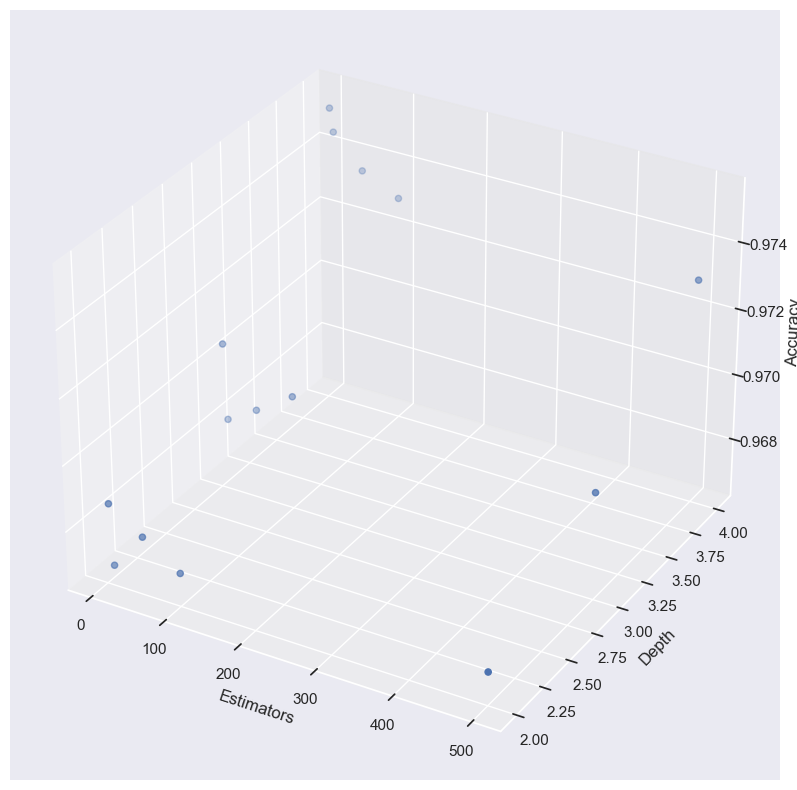

In [33]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

estimators =[row[0] for row in summary_scores]
depths = [row[1] for row in summary_scores]
accuracies = [row[2] for row in summary_scores]

ax.scatter(estimators, depths, accuracies)
ax.set_xlabel('Estimators')
ax.set_ylabel('Depth')
ax.set_zlabel('Accuracy')
plt.show()

In [34]:
# Decipher the most important code
features_importances = DataFrame(RandomForest.feature_importances_,
                                 index = x_train.columns, columns=['importance']).sort_values('importance', ascending = False)
features_importances

,importance
light,0.549141
CO2,0.252483
humidity,0.115114
temperature,0.083262


#### Random Forest With CV 

In [35]:
n_estimators = [5, 10, 50, 100,500]
max_depth = [2,3,4]
best_accuracy = 0
min_f1 = 0
min_rmse =1
summary_scores =[] 
best_model = [[],[],[]]

#Assign training and validiation data 
x_train, x_test, y_train, y_test = train_test_split(df[['temperature','CO2','humidity','light']], df['pir'],test_size=0.2)

for estimator in n_estimators:
  for depth in max_depth:
        
    RandomForest = RandomForestClassifier (n_estimators=estimator, max_depth=depth)

    #Use KFold to split the data into 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    #Perform the 5-fold cross-validation
    for train_index, val_index in kf.split(x_train): 
      x_cv_train, x_cv_val = x_train.iloc[train_index], x_train.iloc[val_index]
      y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
    #Fit the model to the training data 
    RandomForest.fit(x_cv_train, y_cv_train)

    #Test the model on the predictions 
    y_predicted = RandomForest.predict(x_cv_val)

    #Calculate the accuracy of the model's predictions 
    accuracy = accuracy_score (y_cv_val, y_predicted)
    random_rmse = np.sqrt(mean_squared_error(y_cv_val,y_predicted))
    F1 = f1_score(y_cv_val,y_predicted)

    print('Estimator:', estimator,'Depth',depth,'\n' 'Accuracy:', accuracy,'RMSE:',random_rmse, 'F1 score:', F1)
    summary_scores.append([estimator,depth,accuracy,random_rmse, F1])

    if accuracy > best_accuracy:
      best_accuracy=accuracy
      best_model [0] = [estimator,depth,accuracy,random_rmse,F1]
    if F1 > min_f1:
      min_f1 = F1
      best_model [1] = [estimator,depth,accuracy,random_rmse,F1]
    if random_rmse < min_rmse:
      min_rmse = random_rmse
      best_model [2] = [estimator,depth,accuracy,random_rmse,F1]

print ('\n Best Model', best_accuracy, best_model)

Estimator: 5 Depth 2 
Accuracy: 0.9666750031261723 RMSE: 0.1825513540728408 F1 score: 0.09507640067911714
Estimator: 5 Depth 3 
Accuracy: 0.9706139802425909 RMSE: 0.17142350993200736 F1 score: 0.3490304709141274
Estimator: 5 Depth 4 
Accuracy: 0.9744904339127173 RMSE: 0.15971714399926742 F1 score: 0.4742268041237114
Estimator: 10 Depth 2 
Accuracy: 0.9669876203576341 RMSE: 0.18169309189500266 F1 score: 0.0958904109589041
Estimator: 10 Depth 3 
Accuracy: 0.9689883706389896 RMSE: 0.176101190685953 F1 score: 0.21269841269841266
Estimator: 10 Depth 4 
Accuracy: 0.9731149180942854 RMSE: 0.1639667097483957 F1 score: 0.4251336898395722
Estimator: 50 Depth 2 
Accuracy: 0.9664249093410029 RMSE: 0.18323506940265863 F1 score: 0.06282722513089005
Estimator: 50 Depth 3 
Accuracy: 0.9711141678129298 RMSE: 0.1699583248536833 F1 score: 0.3205882352941176
Estimator: 50 Depth 4 
Accuracy: 0.9749906214830562 RMSE: 0.15814353770212633 F1 score: 0.47506561679790027
Estimator: 100 Depth 2 
Accuracy: 0.96529

In [36]:
best_model #row/column 1 accuracy, row 2 rmse, row 3 f1

[[50, 4, 0.9749906214830562, 0.15814353770212633, 0.47506561679790027],
 [50, 4, 0.9749906214830562, 0.15814353770212633, 0.47506561679790027],
 [50, 4, 0.9749906214830562, 0.15814353770212633, 0.47506561679790027]]

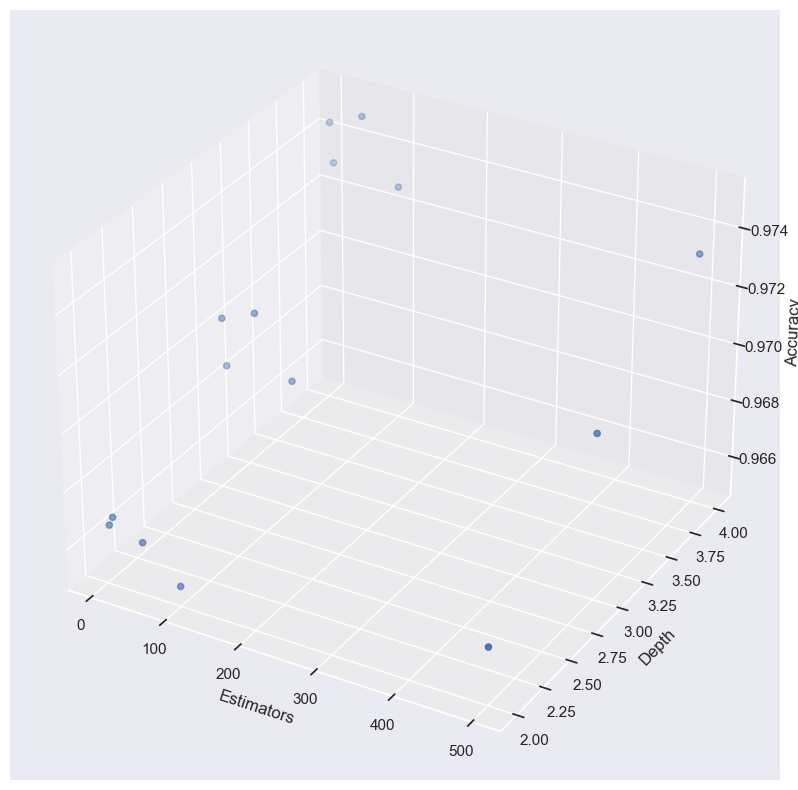

In [37]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

estimators =[row[0] for row in summary_scores]
depths = [row[1] for row in summary_scores]
accuracies = [row[2] for row in summary_scores]

ax.scatter(estimators, depths, accuracies)
ax.set_xlabel('Estimators')
ax.set_ylabel('Depth')
ax.set_zlabel('Accuracy')
plt.show()

### Decision Tree

#### Decision Tree using "GridSearchCV" Method

In [38]:
#Create the decision tree
decision_tree = DecisionTreeClassifier()

#Create the model by fitting to training data
decision_tree.fit(x_train,y_train)

y_predicted = decision_tree.predict(x_test)
decision_rsme = np.sqrt(mean_squared_error(y_test,y_predicted))
print('Decision Tree RSME:',decision_rsme)

#Determine model accuracy
accuracy = accuracy_score (y_test,y_predicted)
print('Decision Tree Accuracy:',accuracy)

# F1 score
F1 = f1_score(y_test,y_predicted)
print('F1 score:', F1)
# Define the parameter grid for tuning
grid_search = {'max_depth': [2,3, 4],
              'min_samples_leaf': [3,5, 10, 15,30]} 

# Create a grid search object to find the best hyperparameters
grid = GridSearchCV(decision_tree, grid_search, cv=5)

# Fit the grid search object to the data
grid.fit(x_train, y_train)

# Print the best hyperparameters
print(grid.best_params_)

# Get the best decision tree model
tree = grid.best_estimator_

Decision Tree RSME: 0.09301933013483606
Decision Tree Accuracy: 0.9913474042212663
F1 score: 0.8756290438533428
{'max_depth': 4, 'min_samples_leaf': 3}


#### Decision Tree with CV 

In [15]:

max_depths = [2,3, 4]
min_samples_leafs = [3,5, 10, 15,30] 
best_accuracy = 0
min_f1 = 0
min_rmse =1
scores = [] 
best_model = [[],[],[]]


#Assign training and validiation data 
x_train, x_test, y_train, y_test = train_test_split(df[['temperature','CO2','humidity','light']], df['pir'],test_size=0.2) 

#Iterate through the decision tree 
for depth in max_depths:
    for samples_leaf in min_samples_leafs:

        #Create the decision tree
        decision_tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_leaf)

        #Use KFold to split the data into 5 folds
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        #Perform the 5-fold cross-validation
        for train_index, val_index in kf.split(x_train): 
            x_cv_train, x_cv_val = x_train.iloc[train_index], x_train.iloc[val_index]
            y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #Create the model by fitting to training data
        decision_tree.fit(x_cv_train,y_cv_train)

        y_predicted = decision_tree.predict(x_cv_val)

        #Calculate the accuracy of the model's predictions 
        accuracy = accuracy_score (y_cv_val, y_predicted)
        decision_rmse = np.sqrt(mean_squared_error(y_cv_val,y_predicted))
        F1 = f1_score(y_cv_val,y_predicted)

        print('Depth:', depth,'sample leaf',samples_leaf,'\n' 'Accuracy:', accuracy,'RMSE:', decision_rmse, 'F1 score:', F1)
        scores.append([depth,samples_leaf,accuracy,decision_rmse, F1 ])


        if accuracy > best_accuracy:
            best_accuracy=accuracy
            best_model [0] = [depth,samples_leaf,accuracy,decision_rmse, F1]
        if F1 > min_f1:
            min_f1 = F1
            best_model [1] = [depth,samples_leaf,accuracy,decision_rmse, F1]
        if decision_rmse < min_rmse:
            min_rmse = decision_rmse
            best_model [2] = [depth,samples_leaf,accuracy,decision_rmse, F1]

print ('\n Best Model', best_accuracy, best_model)

Depth: 2 sample leaf 3 
Accuracy: 0.9691134175315743 RMSE: 0.17574578933341664 F1 score: 0.18211920529801326
Depth: 2 sample leaf 5 
Accuracy: 0.9691134175315743 RMSE: 0.17574578933341664 F1 score: 0.18211920529801326
Depth: 2 sample leaf 10 
Accuracy: 0.9691134175315743 RMSE: 0.17574578933341664 F1 score: 0.18211920529801326
Depth: 2 sample leaf 15 
Accuracy: 0.9691134175315743 RMSE: 0.17574578933341664 F1 score: 0.18211920529801326
Depth: 2 sample leaf 30 
Accuracy: 0.9691134175315743 RMSE: 0.17574578933341664 F1 score: 0.18211920529801326
Depth: 3 sample leaf 3 
Accuracy: 0.9694260347630361 RMSE: 0.1748541255932037 F1 score: 0.19967266775777412
Depth: 3 sample leaf 5 
Accuracy: 0.9692384644241591 RMSE: 0.17538966781381662 F1 score: 0.1986970684039088
Depth: 3 sample leaf 10 
Accuracy: 0.9692384644241591 RMSE: 0.17538966781381662 F1 score: 0.1986970684039088
Depth: 3 sample leaf 15 
Accuracy: 0.9692384644241591 RMSE: 0.17538966781381662 F1 score: 0.1986970684039088
Depth: 3 sample le

In [16]:
best_model #row 1 accuracy, row 2 rmse, row 3 f1

[[4, 3, 0.9721145429536076, 0.1669893920175542, 0.5173160173160174],
 [4, 3, 0.9721145429536076, 0.1669893920175542, 0.5173160173160174],
 [4, 3, 0.9721145429536076, 0.1669893920175542, 0.5173160173160174]]

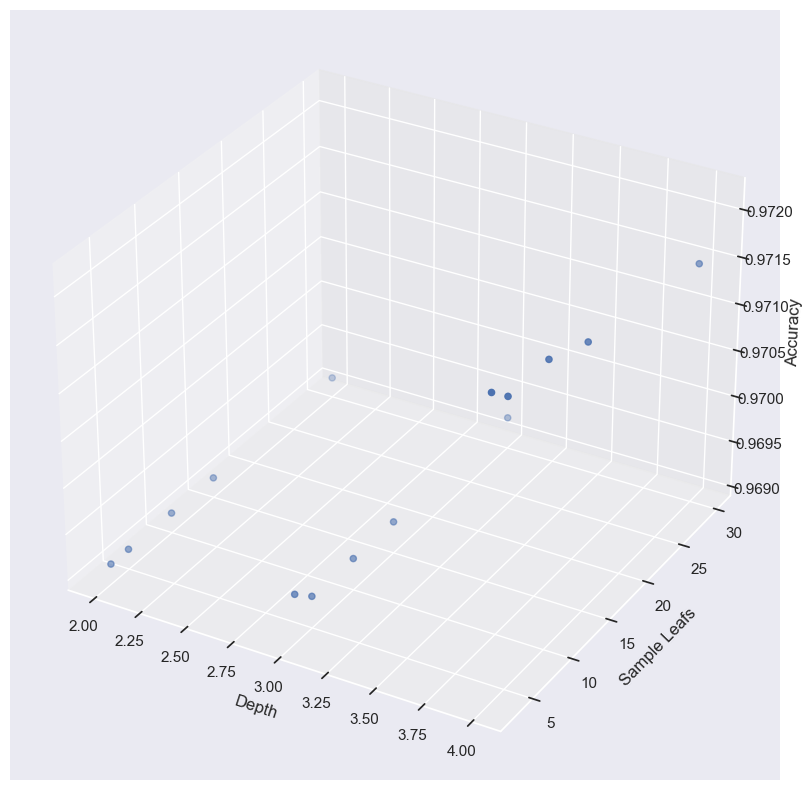

In [17]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

depth =[row[0] for row in scores]
samples_leaf = [row[1] for row in scores]
accuracy = [row[2] for row in scores]

ax.scatter(depth, samples_leaf, accuracy)
ax.set_xlabel('Depth')
ax.set_ylabel('Sample Leafs')
ax.set_zlabel('Accuracy')
plt.show() 

#### Decision Tree Without CV 


In [20]:
max_depths = [2,3, 4]
min_samples_leafs = [3,5, 10, 15,30] 
best_accuracy = 0
min_f1 = 0
min_rmse =1
scores = [] 
best_model = [[],[],[]]


#Assign training and validiation data 
x_train, x_test, y_train, y_test = train_test_split(df[['temperature','CO2','humidity','light']], df['pir'],test_size=0.2) 

#Iterate through the decision tree 
for depth in max_depths:
    for samples_leaf in min_samples_leafs:

        #Create the decision tree
        decision_tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_leaf)

        #Use KFold to split the data into 5 folds
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        
        #Create the model by fitting to training data
        decision_tree.fit(x_train,y_train)

        y_predicted = decision_tree.predict(x_test)

        #Calculate the accuracy of the model's predictions 
        accuracy = accuracy_score (y_test, y_predicted)
        decision_rmse = np.sqrt(mean_squared_error(y_test,y_predicted))
        F1 = f1_score(y_test,y_predicted)

        print('Depth:', depth,'sample leaf',samples_leaf,'\n' 'Accuracy:', accuracy,'RMSE:', decision_rmse, 'F1 score:', F1)
        scores.append([depth,samples_leaf,accuracy,decision_rmse, F1 ])


        if accuracy > best_accuracy:
            best_accuracy=accuracy
            best_model [0] = [depth,samples_leaf,accuracy,decision_rmse, F1]
        if F1 > min_f1:
            min_f1 = F1
            best_model [1] = [depth,samples_leaf,accuracy,decision_rmse, F1]
        if decision_rmse < min_rmse:
            min_rmse = decision_rmse
            best_model [2] = [depth,samples_leaf,accuracy,decision_rmse, F1]

print ('\n Best Model', best_accuracy, best_model)

Depth: 2 sample leaf 3 
Accuracy: 0.9676903070921277 RMSE: 0.17974897192438227 F1 score: 0.1675257731958763
Depth: 2 sample leaf 5 
Accuracy: 0.9676903070921277 RMSE: 0.17974897192438227 F1 score: 0.1675257731958763
Depth: 2 sample leaf 10 
Accuracy: 0.9676903070921277 RMSE: 0.17974897192438227 F1 score: 0.1675257731958763
Depth: 2 sample leaf 15 
Accuracy: 0.9676903070921277 RMSE: 0.17974897192438227 F1 score: 0.1675257731958763
Depth: 2 sample leaf 30 
Accuracy: 0.9676903070921277 RMSE: 0.17974897192438227 F1 score: 0.1675257731958763
Depth: 3 sample leaf 3 
Accuracy: 0.9677903371011304 RMSE: 0.1794705070446664 F1 score: 0.18274111675126903
Depth: 3 sample leaf 5 
Accuracy: 0.9677903371011304 RMSE: 0.1794705070446664 F1 score: 0.18274111675126903
Depth: 3 sample leaf 10 
Accuracy: 0.967740322096629 RMSE: 0.17960979345061062 F1 score: 0.18250950570342206
Depth: 3 sample leaf 15 
Accuracy: 0.967740322096629 RMSE: 0.17960979345061062 F1 score: 0.18250950570342206
Depth: 3 sample leaf 30

In [21]:
best_model #row 1 accuracy, row 2 rmse, row 3 f1

[[4, 3, 0.9704911473442033, 0.1717814095174351, 0.5115894039735099],
 [4, 3, 0.9704911473442033, 0.1717814095174351, 0.5115894039735099],
 [4, 3, 0.9704911473442033, 0.1717814095174351, 0.5115894039735099]]

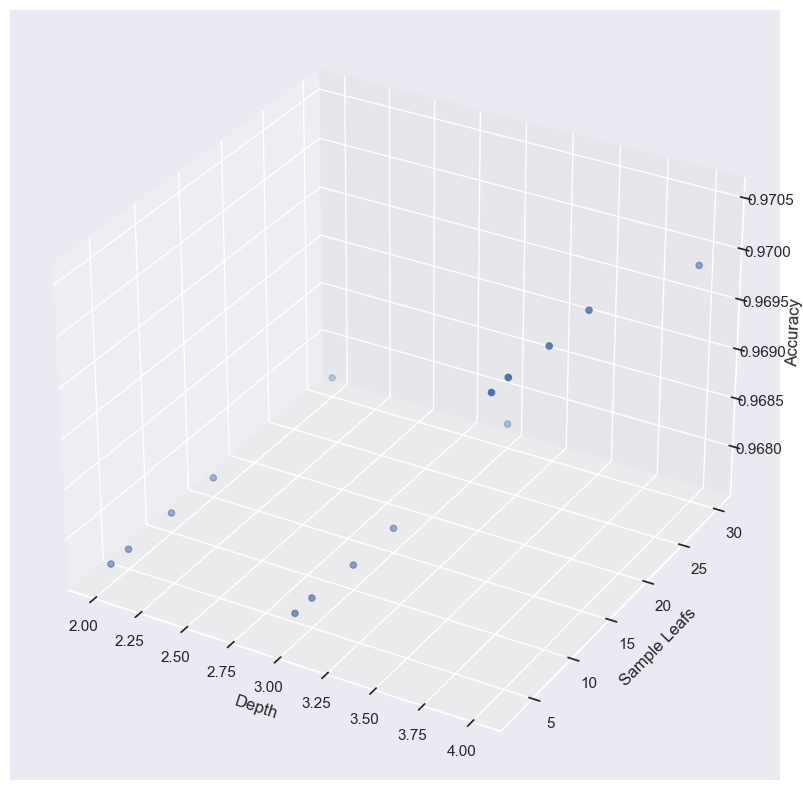

In [22]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

depth =[row[0] for row in scores]
samples_leaf = [row[1] for row in scores]
accuracy = [row[2] for row in scores]

ax.scatter(depth, samples_leaf, accuracy)
ax.set_xlabel('Depth')
ax.set_ylabel('Sample Leafs')
ax.set_zlabel('Accuracy')
plt.show() 

### Artificial Neural Network (ANN)

In [39]:
#Prepare data for neural network 
num_epochs = 10
learning_rate = 0.001

x_train_ANN = x_train.iloc[:40000, :]
y_train_ANN = y_train.iloc[:40000]

x_test_ANN = x_test.iloc[:40000, :]
y_test_ANN = y_test.iloc[:40000]


x_train_ANN = torch.Tensor(x_train_ANN.values).float()
y_train_ANN = torch.Tensor(y_train_ANN.values).float().unsqueeze(1)

x_test_ANN = torch.Tensor(x_test_ANN.values).float()
y_test_ANN = torch.Tensor(y_test_ANN.values).float().unsqueeze(1)

In [40]:
input_size = 4 #features 
fc1_size = 8 #arbritary 
fc2_size = 2 #arbritary
output_size = 1

class ArtNet (nn.Module):
    def __init__ (self, input_size, fc1_size, fc2_size, output_size):
        super(ArtNet,self).__init__()
        self.fc1 = nn.Linear(input_size,fc1_size)
        self.fc2 = nn.Linear(fc1_size,fc2_size)
        self.fc3 = nn.Linear (fc2_size, output_size)

    def forward (self,x):
        x=torch.relu(self.fc1(x))
        x=x.view(-1,fc1_size)
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return x 

In [41]:
model = ArtNet(input_size, fc1_size, fc2_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range (num_epochs):

    #forward pass
    outputs=model(x_train_ANN)
    loss = criterion(outputs,y_train_ANN)

    #backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [42]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_ANN = model(x_test_ANN)
    y_pred_ANN = (y_pred_ANN > 0.5).float() # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test_ANN.numpy(), y_pred_ANN.numpy())
    print(f'Test accuracy: {accuracy:.4f}')
        
    # F1 score
    F1 = f1_score(y_test_ANN, y_pred_ANN)
    print('F1 score:', F1)
    # Calculate RMSE on test set
    rmse = torch.sqrt(criterion(y_pred_ANN, y_test_ANN))
    print(f'RMSE: {rmse.item():.3f}')


Test accuracy: 0.9658
F1 score: 0.022889842632331903
RMSE: 0.185
